数据集切分完成：Train=(127945, 24), Test=(27417, 24)

=== SHAP 解释：Ridge ===

-- 全局重要性（mean(|SHAP|)）Top 15 --
            feature  mean(|SHAP|)
0     CO2_rollmean3     38.855185
1          CO2_lag3     11.925159
2    CO2_rollmean24      6.295721
3   CO2_rollmean168      1.869190
4         CO2_lag12      1.529180
5    CO2_rollmean72      1.218697
6         CO2_lag24      1.216559
7          CO2_lag6      1.115782
8     CO2_rollmean6      0.787019
9    CO2_rollmean48      0.487691
10   CO2_rollmean12      0.451552
11        CO2_lag72      0.280854
12        CO2_lag48      0.222727
13             hour      0.035624
14    CO2_rollvar24      0.029187


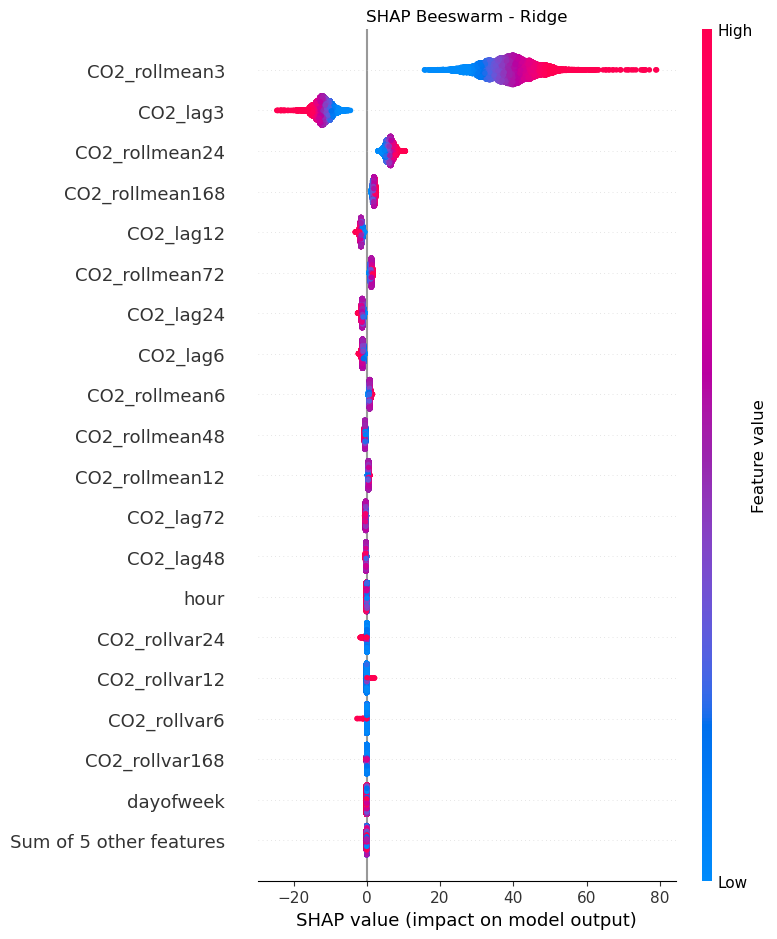

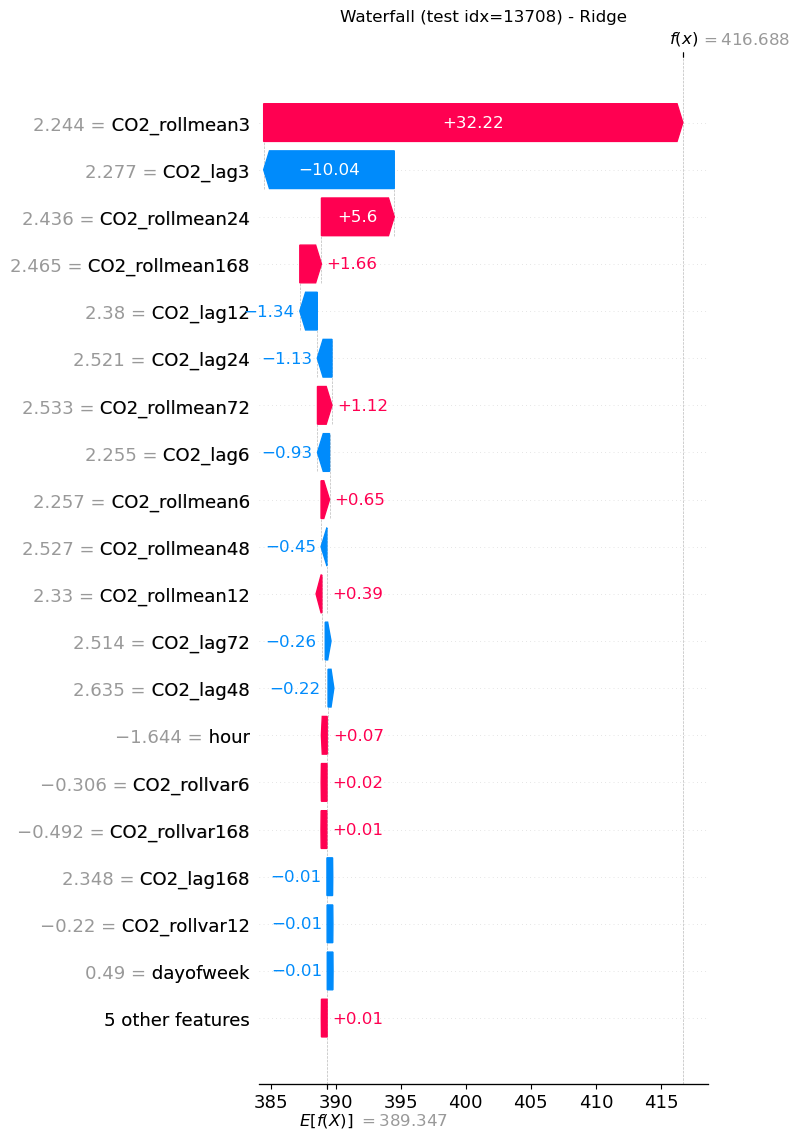

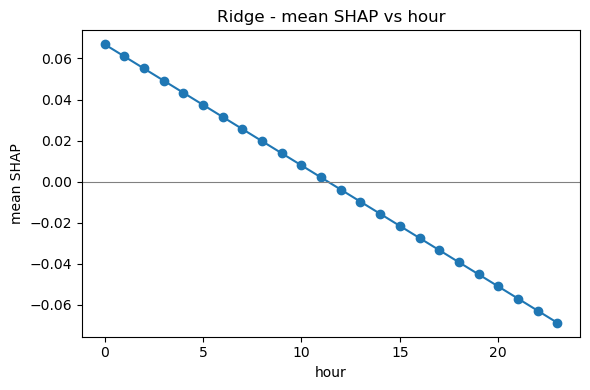

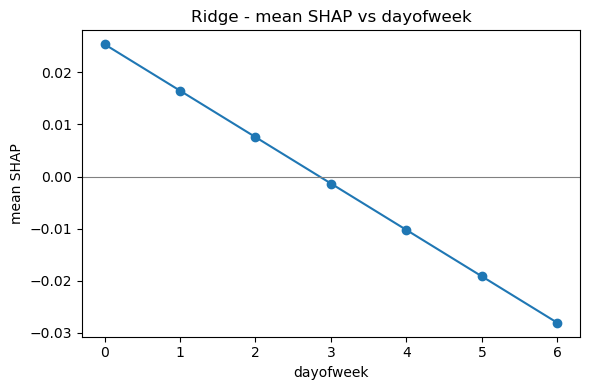

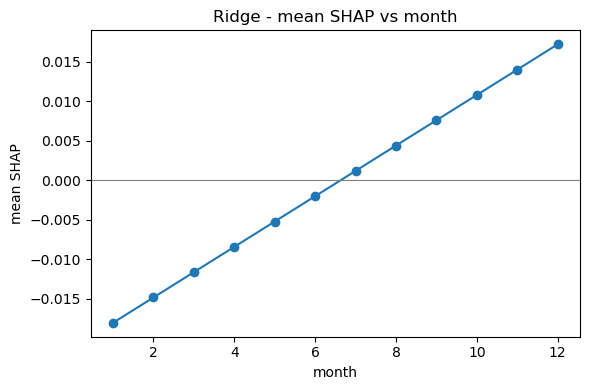


=== SHAP 解释：Lasso ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.468e+04, tolerance: 1.740e+03
  model = cd_fast.enet_coordinate_descent(



-- 全局重要性（mean(|SHAP|)）Top 15 --
            feature  mean(|SHAP|)
0     CO2_rollmean3     50.729695
1     CO2_rollmean6     13.779643
2          CO2_lag3      8.013644
3    CO2_rollmean12      5.272064
4          CO2_lag6      4.971304
5         CO2_lag12      1.761369
6    CO2_rollmean24      0.999034
7        CO2_lag168      0.423099
8         CO2_lag72      0.327004
9         CO2_lag48      0.311257
10  CO2_rollmean168      0.169082
11        CO2_lag24      0.098107
12             hour      0.031245
13    CO2_rollvar24      0.019906
14     CO2_rollvar6      0.015178


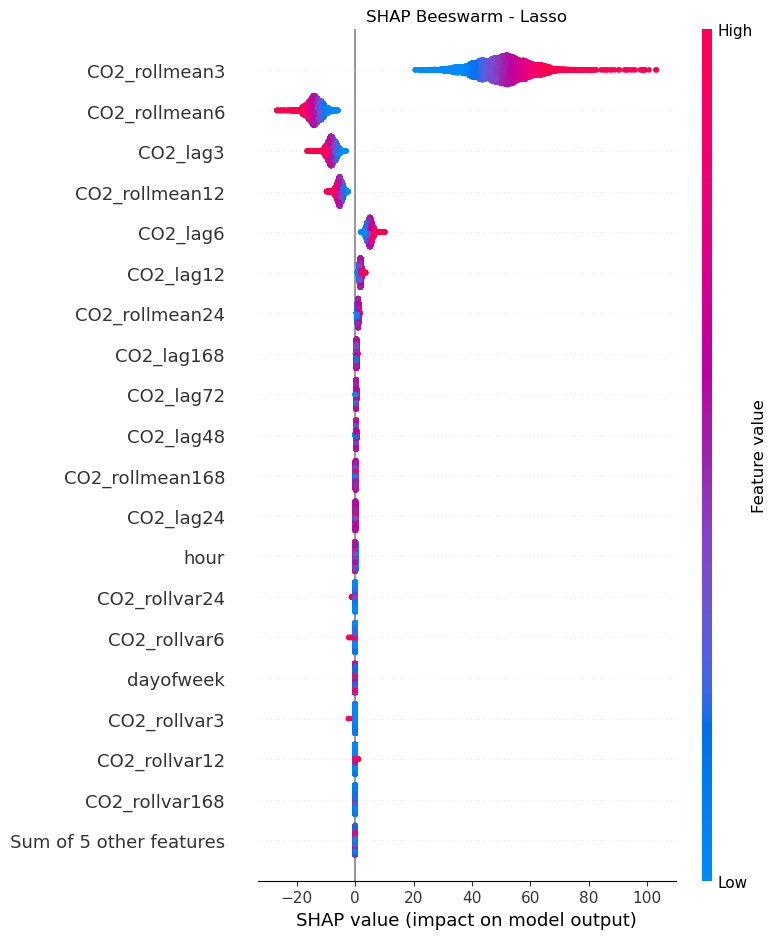

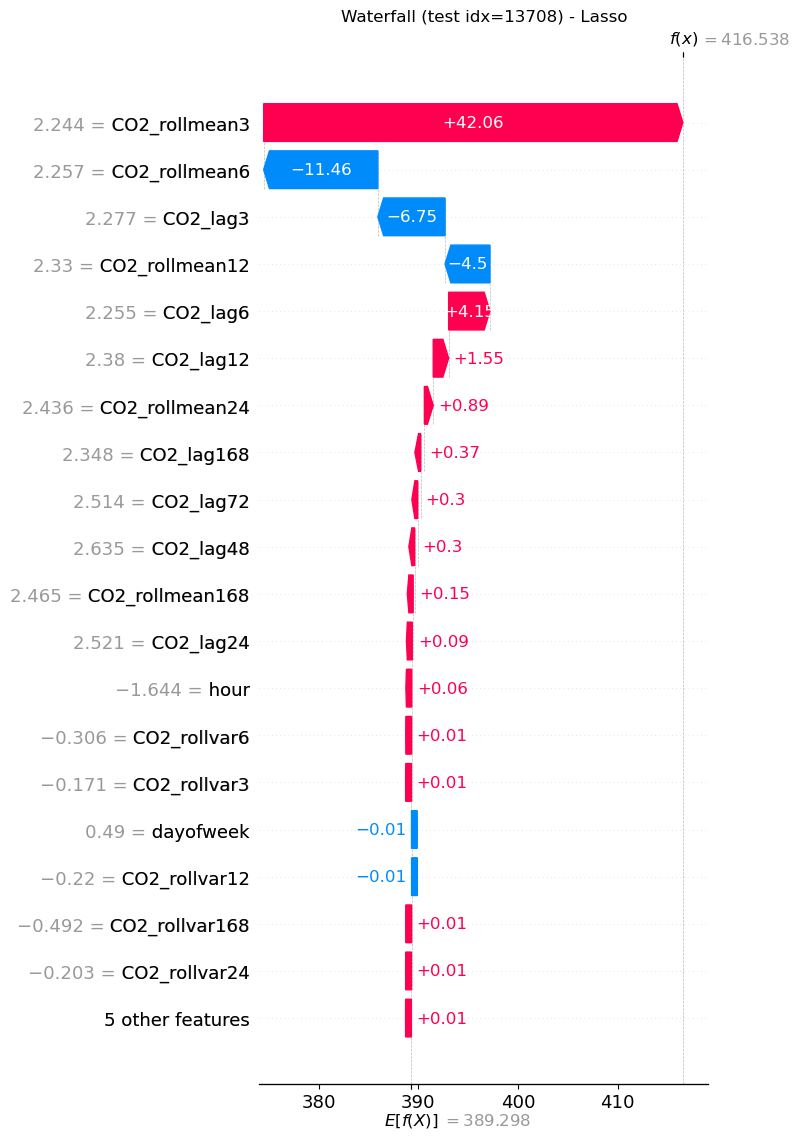

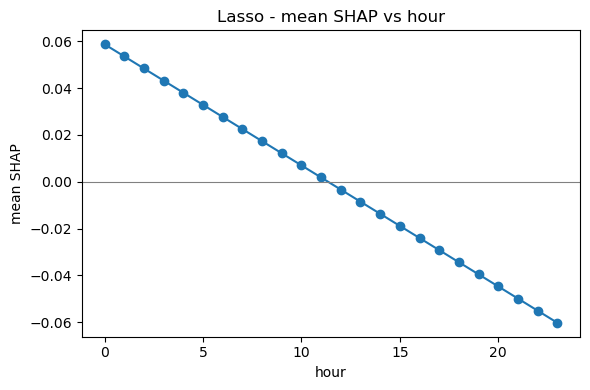

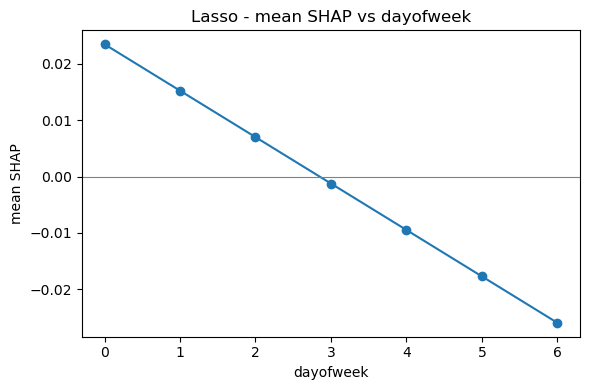

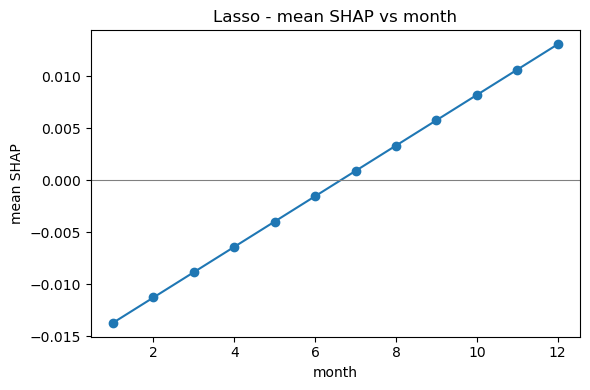


=== SHAP 解释：ElasticNet ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.655e+04, tolerance: 1.740e+03
  model = cd_fast.enet_coordinate_descent(



-- 全局重要性（mean(|SHAP|)）Top 15 --
           feature  mean(|SHAP|)
0    CO2_rollmean3     41.923564
1         CO2_lag3     11.992617
2   CO2_rollmean12      5.893625
3         CO2_lag6      2.632015
4        CO2_lag12      2.525585
5    CO2_rollmean6      1.895823
6   CO2_rollmean72      1.713099
7        CO2_lag48      0.861672
8        CO2_lag72      0.665889
9        CO2_lag24      0.636640
10      CO2_lag168      0.550592
11  CO2_rollmean24      0.548700
12  CO2_rollmean48      0.046848
13            hour      0.030701
14   CO2_rollvar24      0.025587


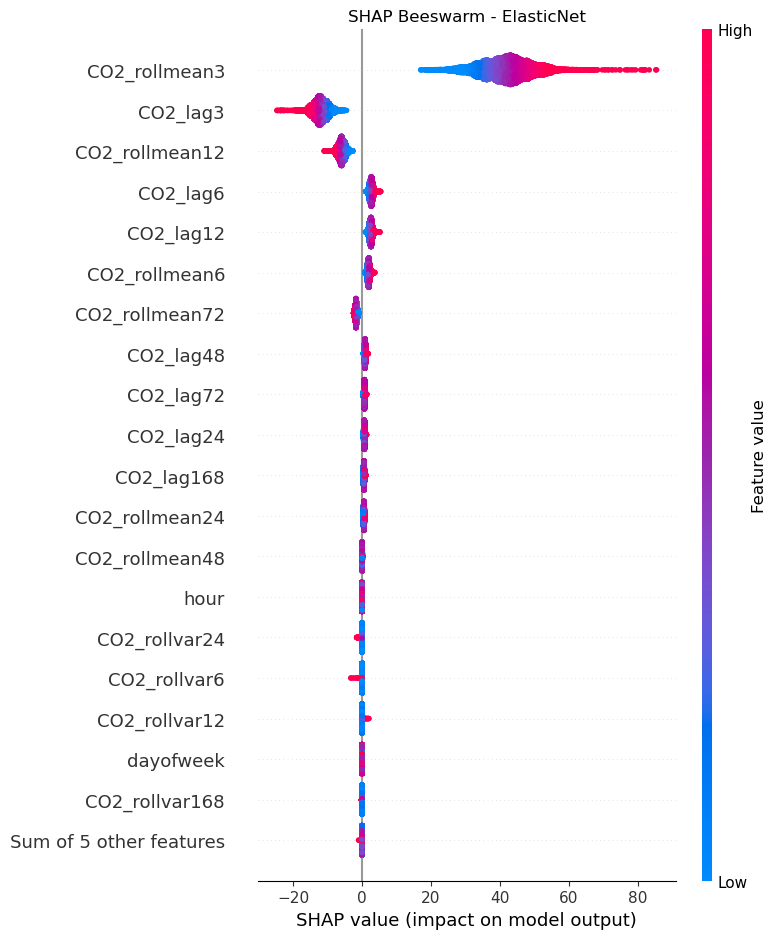

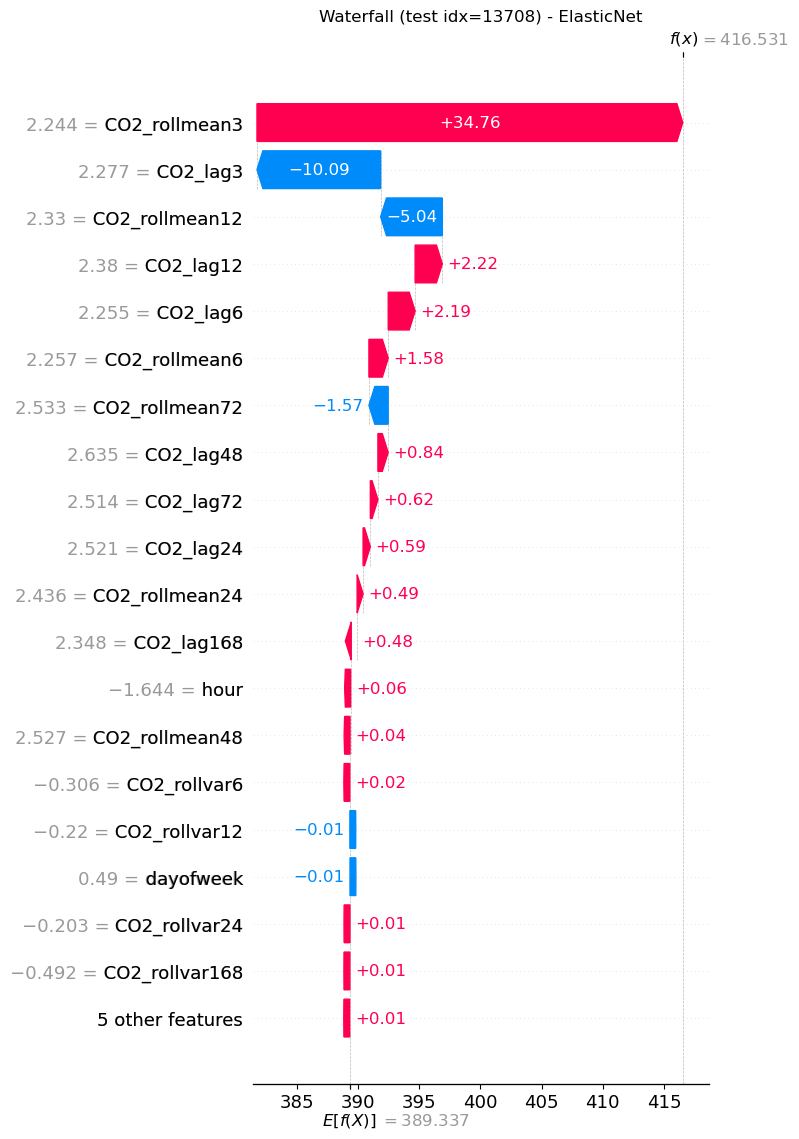

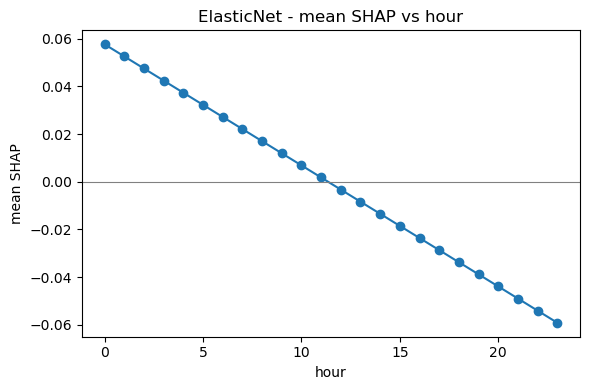

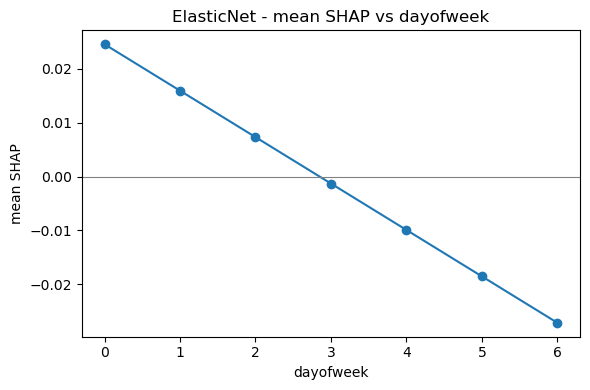

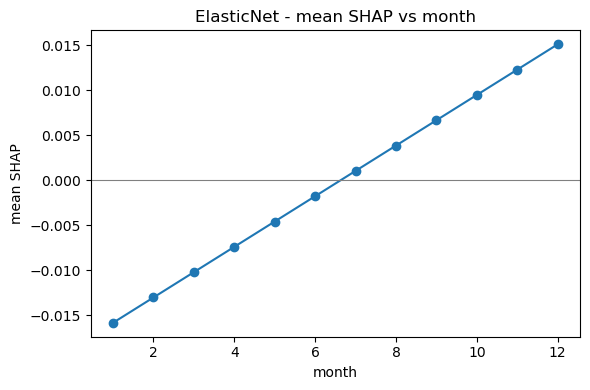


=== 跨模型全局重要性对比（mean(|SHAP|)，按各模型列降序）Top 20 ===
model            ElasticNet      Lasso      Ridge
feature                                          
CO2_rollmean3     41.923564  50.729695  38.855185
CO2_lag3          11.992617   8.013644  11.925159
CO2_rollmean24     0.548700   0.999034   6.295721
CO2_rollmean168    0.002583   0.169082   1.869190
CO2_lag12          2.525585   1.761369   1.529180
CO2_rollmean72     1.713099   0.000000   1.218697
CO2_lag24          0.636640   0.098107   1.216559
CO2_lag6           2.632015   4.971304   1.115782
CO2_rollmean6      1.895823  13.779643   0.787019
CO2_rollmean48     0.046848   0.000000   0.487691
CO2_rollmean12     5.893625   5.272064   0.451552
CO2_lag72          0.665889   0.327004   0.280854
CO2_lag48          0.861672   0.311257   0.222727
hour               0.030701   0.031245   0.035624
CO2_rollvar24      0.025587   0.019906   0.029187
CO2_rollvar12      0.019303   0.011262   0.020748
CO2_rollvar6       0.022617   0.015178   0.018472
CO

In [9]:
# =======================
# SHAP 可解释性分析（线性模型）
# =======================
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from pathlib import Path
import pandas as pd

# ==== 路径 ====
datadir = Path("../data")
data_file = datadir / "dataset_taskA.csv"

# ==== 读取数据 ====
df = pd.read_csv(data_file, parse_dates=["timestamp"], index_col="timestamp")

TARGET = "target_next1h"
X = df.drop(columns=[TARGET, "CO2"])
y = df[TARGET]

# 按时间顺序切分：70 / 15 / 15（保持和训练脚本一致）
n = len(df)
i_train_end = int(n * 0.70)
i_val_end   = int(n * 0.85)
X_train, y_train = X.iloc[:i_train_end], y.iloc[:i_train_end]
X_val,   y_val   = X.iloc[i_train_end:i_val_end], y.iloc[i_train_end:i_val_end]
X_test,  y_test  = X.iloc[i_val_end:], y.iloc[i_val_end:]

print(f"数据集切分完成：Train={X_train.shape}, Test={X_test.shape}")


# ---- 配置 ----
MAX_DISPLAY = 20         # beeswarm展示的最多特征数
EXCLUDE_MAIN_CO2_IN_TABLE = True  # 打印全局表时是否排除 'CO2' 主特征（图里仍保留）

# 与训练一致的三种线性模型（只用于解释；训练非常快）
linear_models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5),
}

feature_names = X_train.columns.tolist()

global_tables = []   # 存放全局重要性表（mean(|SHAP|)）
waterfall_example_idx = len(X_test) // 2  # 选测试集居中一条做示例

for name, base_model in linear_models.items():
    print(f"\n=== SHAP 解释：{name} ===")

    # 1) 拟合与变换（保持与训练时相同的“标准化+线性”口径）
    scaler = StandardScaler().fit(X_train)
    Xtr = scaler.transform(X_train)
    Xte = scaler.transform(X_test)
    model = base_model.fit(Xtr, y_train)

    # 2) 解释器（线性模型用 LinearExplainer 更稳）
    explainer = shap.LinearExplainer(model, Xtr, feature_names=feature_names)
    shap_values = explainer(Xte)  # shap.Explanation: .values shape = (n_samples, n_features)

        # —— 缓存：本模型的 SHAP 与已拟合管线（后续稳健性与 PDP/ICE 复用）——
    if "shap_store" not in locals():
        shap_store = {}
    if "fitted_pipes" not in locals():
        fitted_pipes = {}
    shap_store[name] = shap_values
    # 用“已拟合”的 scaler 和 model 组一个可直接预测的 Pipeline
    fitted_pipes[name] = Pipeline([("scaler", scaler), ("model", model)])


    # 3) 全局重要性（mean(|shap|)）
    mean_abs = np.mean(np.abs(shap_values.values), axis=0)
    global_importance = (
        pd.DataFrame({"feature": feature_names, "mean(|SHAP|)": mean_abs})
        .sort_values("mean(|SHAP|)", ascending=False)
        .reset_index(drop=True)
    )

    # 可选：表里淡化 CO2 这列（图里仍完整展示）
    table_to_print = global_importance.copy()
    if EXCLUDE_MAIN_CO2_IN_TABLE and "CO2" in table_to_print["feature"].values:
        table_to_print = table_to_print[table_to_print["feature"] != "CO2"].reset_index(drop=True)

    print("\n-- 全局重要性（mean(|SHAP|)）Top 15 --")
    print(table_to_print.head(15))

    # 4) beeswarm 总览（Top MAX_DISPLAY）
    plt.figure(figsize=(8, 6))
    shap.plots.beeswarm(shap_values, max_display=MAX_DISPLAY, show=False)
    plt.title(f"SHAP Beeswarm - {name}")
    plt.tight_layout()
    plt.show()

    # 5) 单样本 waterfall（局部解释）
    #    注意：waterfall用到单行 Explanation
    try:
        plt.figure(figsize=(7, 5))
        shap.plots.waterfall(shap_values[waterfall_example_idx], show=False, max_display=MAX_DISPLAY)
        plt.title(f"Waterfall (test idx={waterfall_example_idx}) - {name}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[提示] Waterfall 绘制失败（{name}）：{e}")

    # 6) 时间特征的 SHAP 折线（若存在）
    for time_feat in ["hour", "dayofweek", "month"]:
        if time_feat in feature_names:
            j = feature_names.index(time_feat)
            # 将该特征在测试集的取值与对应 SHAP 取出
            tf_vals = X_test[time_feat].values
            tf_shap = shap_values.values[:, j]

            # groupby 取均值（展示平均贡献随取值变化）
            line_df = (
                pd.DataFrame({time_feat: tf_vals, "shap": tf_shap})
                .groupby(time_feat, as_index=False)["shap"]
                .mean()
                .sort_values(time_feat)
            )

            plt.figure(figsize=(6, 4))
            plt.plot(line_df[time_feat], line_df["shap"], marker="o")
            plt.axhline(0, color="gray", linewidth=0.8)
            plt.xlabel(time_feat)
            plt.ylabel("mean SHAP")
            plt.title(f"{name} - mean SHAP vs {time_feat}")
            plt.tight_layout()
            plt.show()

    # 收集全局表（完整保留，方便后面跨模型对比）
    global_importance["model"] = name
    global_tables.append(global_importance)

# 7) 跨模型对比（按 mean(|SHAP|) 透视）
global_all = pd.concat(global_tables, axis=0, ignore_index=True)
pivot_top = (
    global_all.pivot_table(index="feature", columns="model", values="mean(|SHAP|)", aggfunc="mean")
    .fillna(0.0)
    .sort_values(by=list(linear_models.keys()), ascending=False)
)
print("\n=== 跨模型全局重要性对比（mean(|SHAP|)，按各模型列降序）Top 20 ===")
print(pivot_top.head(20).round(6))


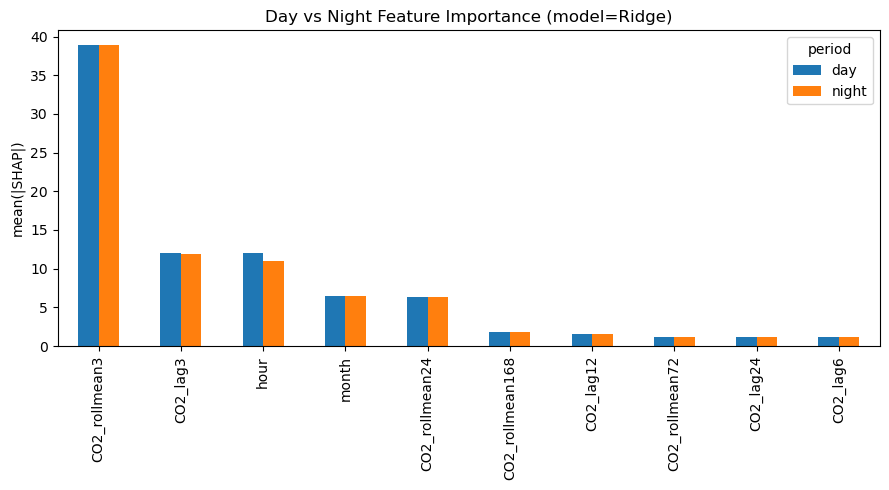

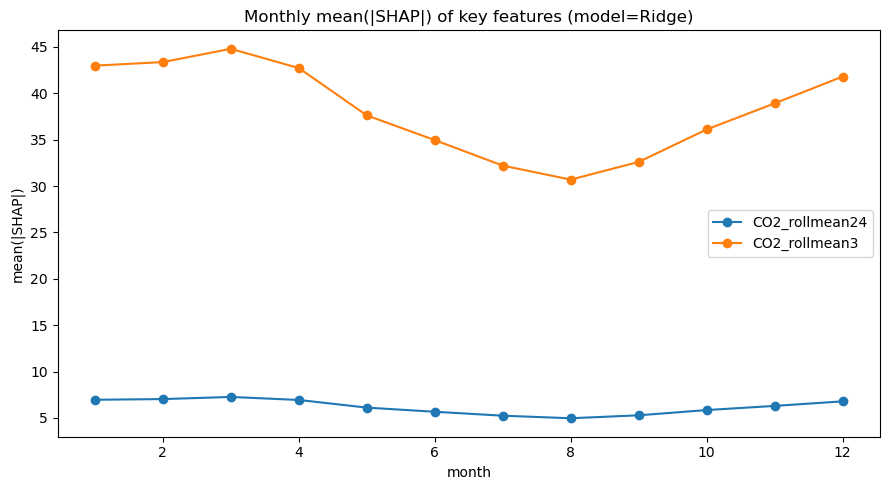

In [10]:
# =======================
# 稳定性检验：分月份 / 昼夜 的 mean(|SHAP|)
# =======================
import numpy as np
import matplotlib.pyplot as plt

# 选择用于稳健性可视化的模型：优先使用你之前选出的 best（若无就用 Ridge）
_model_name = locals().get("best_name", "Ridge")
if "shap_store" not in locals() or _model_name not in shap_store:
    # 若没缓存到该模型的 SHAP，就回退为字典里第一个可用的
    _model_name = next(iter(shap_store.keys()))

sv = shap_store[_model_name]                    # shap.Explanation
feat_names = list(getattr(sv, "feature_names", feature_names))
sv_abs = np.abs(sv.values)

# 组装 DataFrame（索引对齐 X_test）
shap_df = pd.DataFrame(sv_abs, columns=feat_names, index=X_test.index)
shap_df["hour"] = shap_df.index.hour
shap_df["month"] = shap_df.index.month
shap_df["period"] = np.where(shap_df["hour"].between(6, 18), "day", "night")

# —— 昼夜对比：取 Top-10 画柱状图 ——
daynight_imp = shap_df.groupby("period")[feat_names].mean().T   # 行=特征，列=day/night
top10 = daynight_imp.mean(axis=1).sort_values(ascending=False).head(10).index
ax = daynight_imp.loc[top10].plot(kind="bar", figsize=(9, 5))
ax.set_ylabel("mean(|SHAP|)")
ax.set_title(f"Day vs Night Feature Importance (model={_model_name})")
plt.tight_layout()
plt.show()

# —— 月份稳定性：关键特征随月份的 mean(|SHAP|) 折线 ——
monthly_imp = shap_df.groupby("month")[feat_names].mean()
key_feats = [f for f in ["CO2", "CO2_lag1", "CO2_rollmean24", "CO2_rollmean3"] if f in feat_names]
plt.figure(figsize=(9, 5))
for f in key_feats:
    plt.plot(monthly_imp.index, monthly_imp[f], marker="o", label=f)
plt.xlabel("month")
plt.ylabel("mean(|SHAP|)")
plt.title(f"Monthly mean(|SHAP|) of key features (model={_model_name})")
plt.legend()
plt.tight_layout()
plt.show()


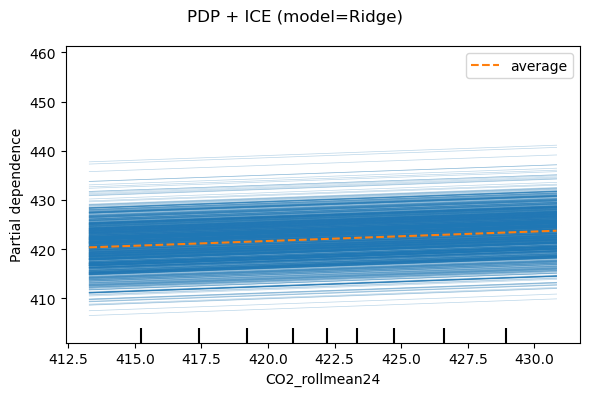

In [11]:
# =======================
# PDP + ICE （关键特征响应曲线）
# =======================
from sklearn.inspection import PartialDependenceDisplay

# 复用上面缓存的已拟合管线
estimator = fitted_pipes[_model_name]

features_to_plot = [f for f in ["CO2_lag1", "CO2_rollmean24"] if f in X_test.columns]
if features_to_plot:
    fig, ax = plt.subplots(1, len(features_to_plot), figsize=(6*len(features_to_plot), 4))
    PartialDependenceDisplay.from_estimator(
        estimator, X_test, features_to_plot,
        kind="both",            # PDP + ICE
        grid_resolution=30,
        ax=ax
    )
    plt.suptitle(f"PDP + ICE (model={_model_name})")
    plt.tight_layout()
    plt.show()
else:
    print("[PDP/ICE] 指定特征在数据集中不存在，已跳过。")


In [18]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, shap
from sklearn.cluster import KMeans

# —— 取出管道里的 scaler 和线性模型
scaler = model.named_steps["scaler"]
lin    = model.named_steps["model"]

# —— 按模型输入空间计算 SHAP
X_tr_t = scaler.transform(X_train)
X_te_t = scaler.transform(X_test)
explainer   = shap.LinearExplainer(lin, X_tr_t)
sv          = explainer.shap_values(X_te_t)
base        = explainer.expected_value

# —— 打包成 Explanation，保留原始列名/值，便于作图
shap_exp = shap.Explanation(
    values=sv,
    base_values=np.repeat(base, len(X_test)),
    data=X_test.values,
    feature_names=X_test.columns.tolist()
)


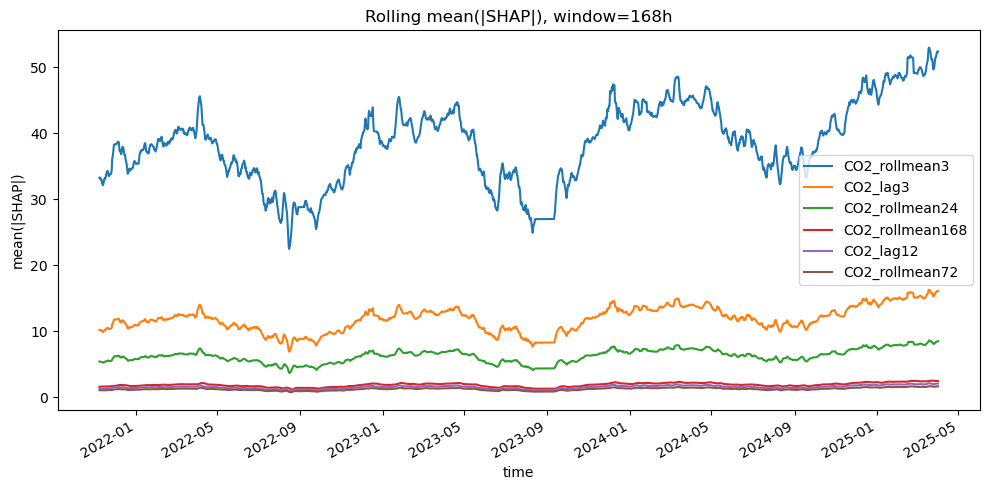

In [20]:
# 选全局最重要的前K个特征
abs_df   = pd.DataFrame(np.abs(shap_exp.values), index=X_test.index, columns=X_test.columns)
top_feats = abs_df.mean().sort_values(ascending=False).head(6).index

# 以一周(168h)为窗口做滚动平均
rolling_h = 168
roll_imp  = abs_df[top_feats].rolling(rolling_h, min_periods=rolling_h).mean()

ax = roll_imp.plot(figsize=(10,5))
ax.set_title(f"Rolling mean(|SHAP|), window={rolling_h}h")
ax.set_xlabel("time"); ax.set_ylabel("mean(|SHAP|)")
plt.tight_layout(); plt.show()


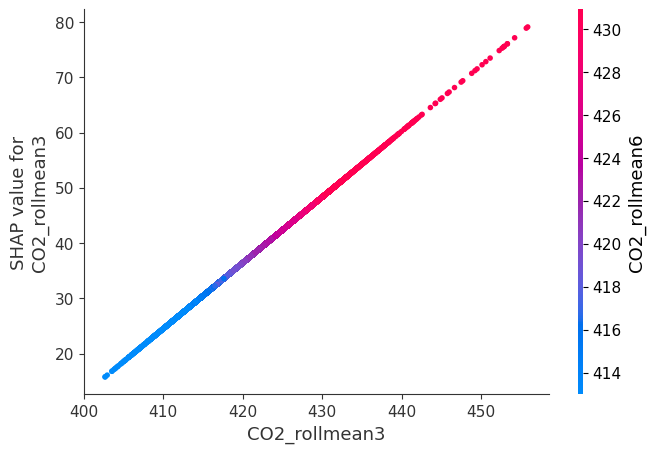

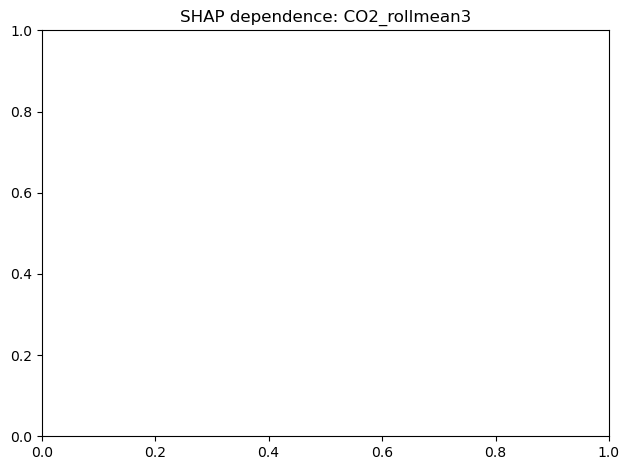

CO2_rollmean3: corr(feature, y_test)=0.983, corr(feature, SHAP)=1.000


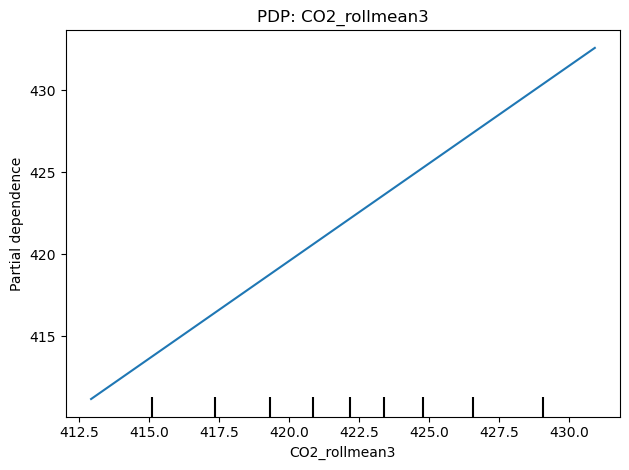

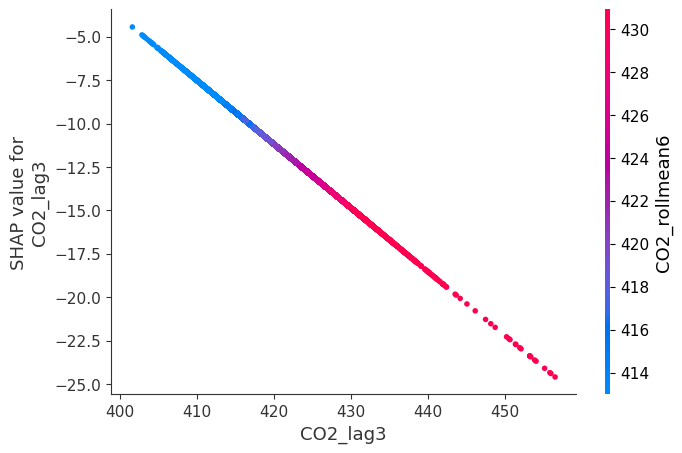

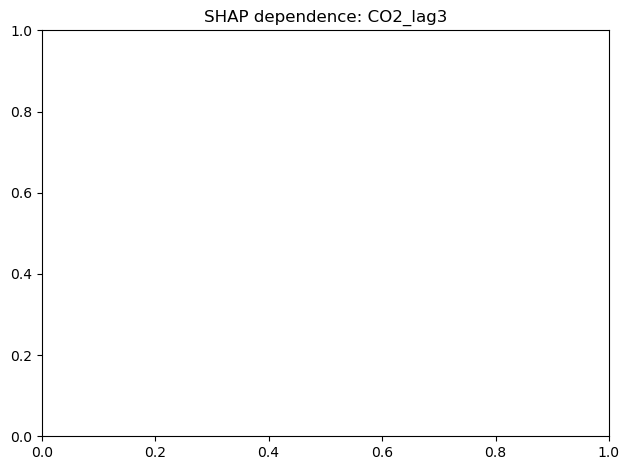

CO2_lag3: corr(feature, y_test)=0.954, corr(feature, SHAP)=-1.000


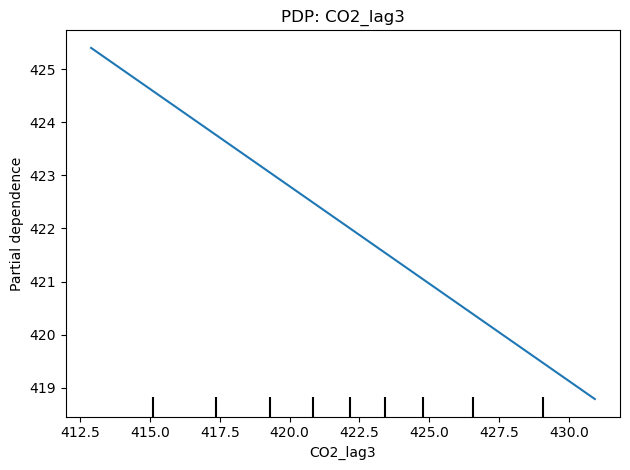

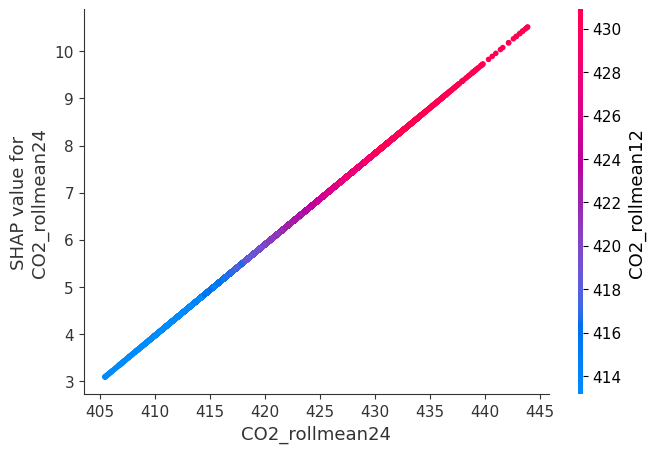

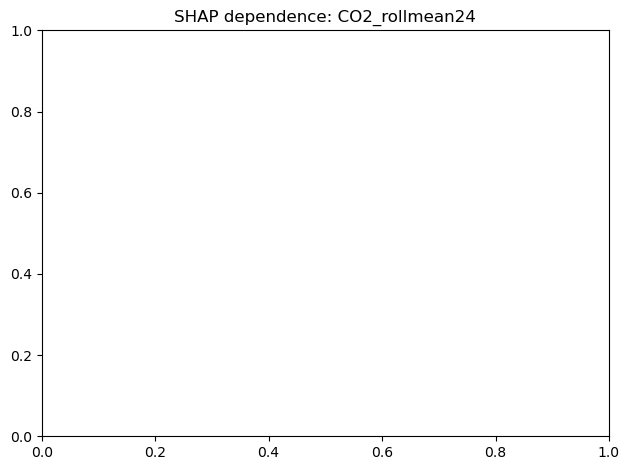

CO2_rollmean24: corr(feature, y_test)=0.934, corr(feature, SHAP)=1.000


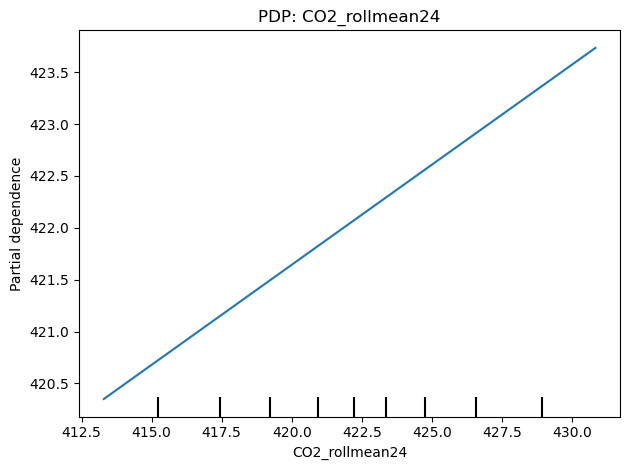

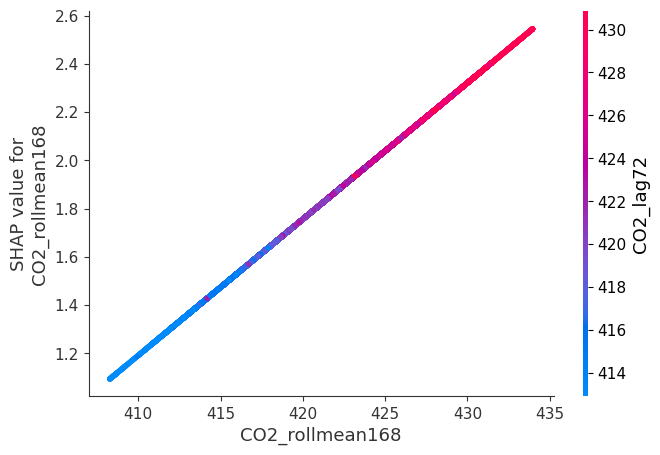

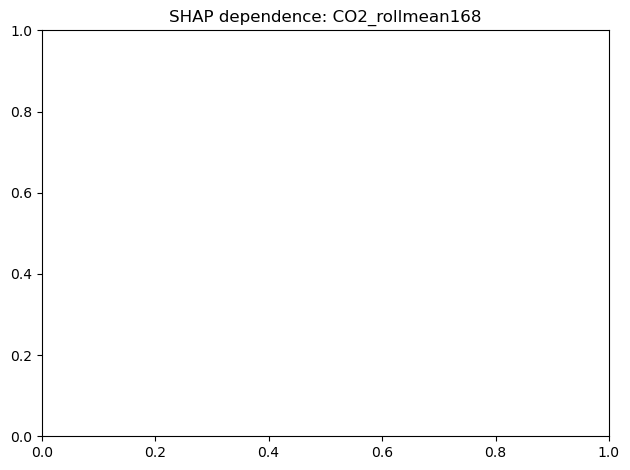

CO2_rollmean168: corr(feature, y_test)=0.882, corr(feature, SHAP)=1.000


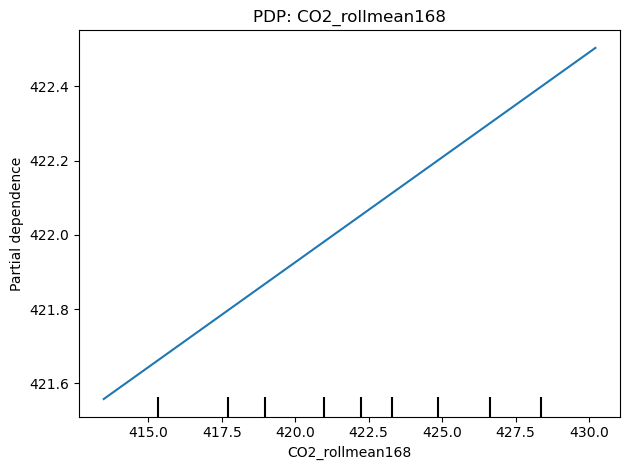

In [22]:
# 取前4个关键特征做深入分析
focus_feats = list(top_feats[:4])

for feat in focus_feats:
    # (a) SHAP dependence plot：特征值 vs 该特征的SHAP贡献
    shap.dependence_plot(feat, shap_exp.values, X_test, feature_names=X_test.columns, show=True)
    plt.title(f"SHAP dependence: {feat}"); plt.tight_layout(); plt.show()

    # (b) 相关性：与目标、与SHAP的皮尔逊相关（只是相关，不代表因果）
    idx = X_test.columns.get_loc(feat)
    corr_y    = pd.Series(X_test[feat]).corr(y_test)
    corr_shap = pd.Series(X_test[feat]).corr(pd.Series(shap_exp.values[:, idx], index=X_test.index))
    print(f"{feat}: corr(feature, y_test)={corr_y:.3f}, corr(feature, SHAP)={corr_shap:.3f}")

    # (c) PDP（偏依赖）作为全局边际效应的对照
    from sklearn.inspection import PartialDependenceDisplay
    _ = PartialDependenceDisplay.from_estimator(model, X_test, [feat])
    plt.title(f"PDP: {feat}"); plt.tight_layout(); plt.show()


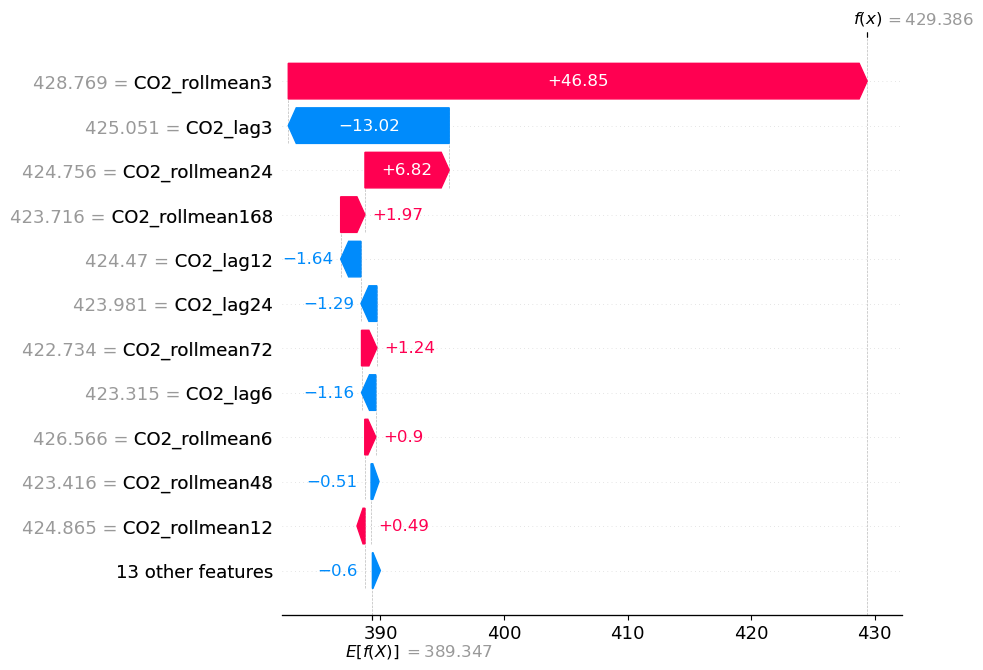

[异常样本] 2022-12-10 14:00:00 | y_true=456.020, y_pred=429.386, resid=26.634


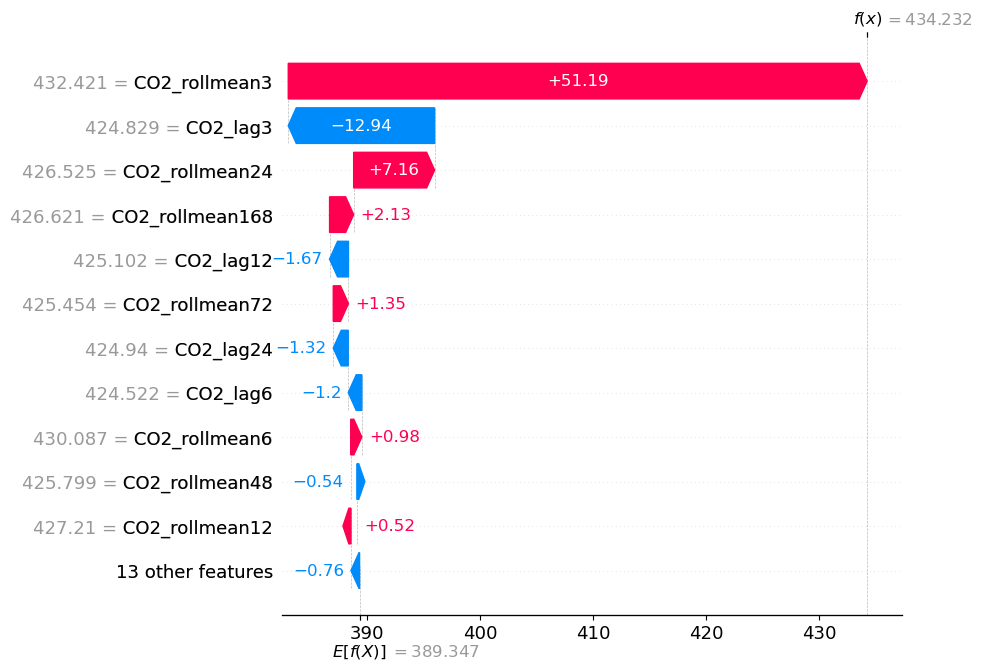

[异常样本] 2023-12-02 08:00:00 | y_true=451.978, y_pred=434.232, resid=17.746


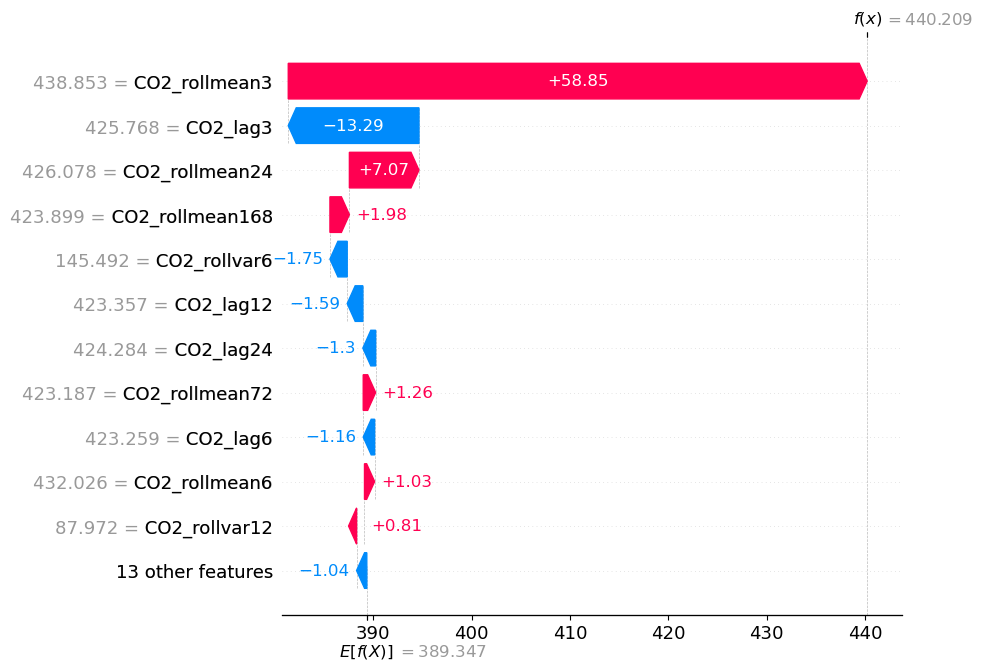

[异常样本] 2022-12-10 15:00:00 | y_true=455.202, y_pred=440.209, resid=14.993


In [24]:
# 计算残差
y_pred     = model.predict(X_test)
residuals  = (y_test - y_pred).rename("residual")

# 取残差绝对值最大的N条
N = 3
worst_ts = residuals.abs().nlargest(N).index

for ts in worst_ts:
    i = X_test.index.get_loc(ts)
    exp_i = shap.Explanation(
        values=shap_exp.values[i],
        base_values=shap_exp.base_values[i],
        data=X_test.iloc[i].values,
        feature_names=X_test.columns
    )
    shap.plots.waterfall(exp_i, max_display=12, show=True)
    print(f"[异常样本] {ts} | y_true={y_test.loc[ts]:.3f}, y_pred={y_pred[X_test.index.get_loc(ts)]:.3f}, resid={residuals.loc[ts]:.3f}")



Cluster sizes:
 0     8681
1     6745
2    11991
Name: count, dtype: int64


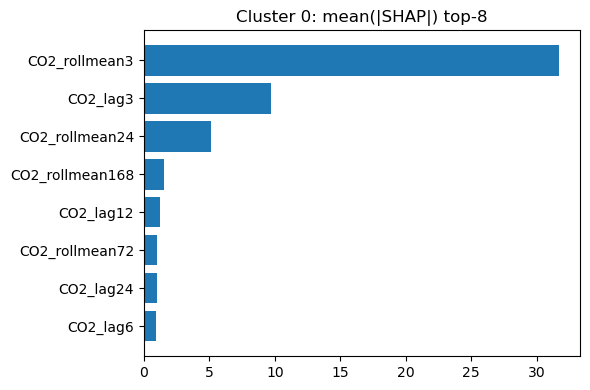

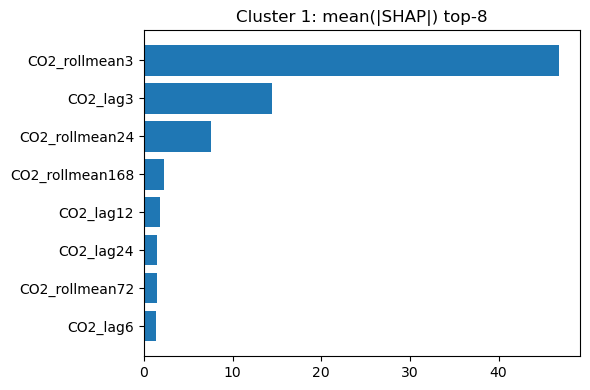

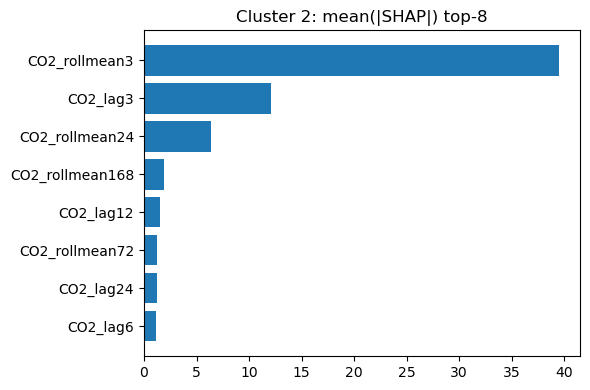

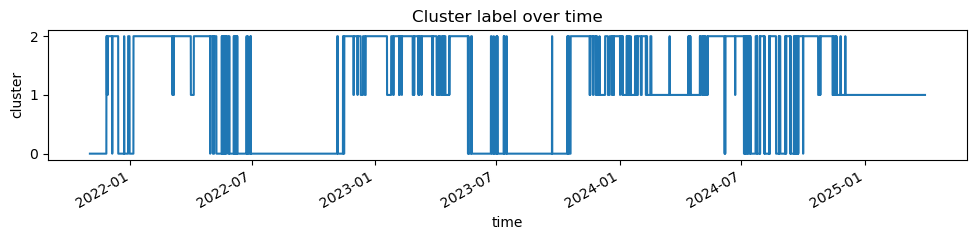

In [26]:
from sklearn.preprocessing import StandardScaler as SS
# 对 SHAP 矩阵做聚类（每一行是一个样本的“解释向量”）
S = SS().fit_transform(shap_exp.values)
k = 3
km = KMeans(n_clusters=k, n_init=20, random_state=0)
labels = km.fit_predict(S)

# 簇大小
cluster_sizes = pd.Series(labels, index=X_test.index).value_counts().sort_index()
print("\nCluster sizes:\n", cluster_sizes)

# 每个簇的 top 贡献特征
for c in range(k):
    sv_c = shap_exp.values[labels == c]
    if sv_c.size == 0: 
        continue
    mean_abs_c = np.mean(np.abs(sv_c), axis=0)
    idx = np.argsort(mean_abs_c)[::-1][:8]
    feats = X_test.columns[idx]; vals = mean_abs_c[idx]

    plt.figure(figsize=(6,4))
    plt.barh(feats[::-1], vals[::-1])
    plt.title(f"Cluster {c}: mean(|SHAP|) top-8")
    plt.tight_layout(); plt.show()

# （可选）聚类时间轴，看看不同“策略”在时间上如何切换
plt.figure(figsize=(10,2.5))
pd.Series(labels, index=X_test.index).plot()
plt.title("Cluster label over time"); plt.xlabel("time"); plt.ylabel("cluster")
plt.tight_layout(); plt.show()
